In [1]:
import sys

sys.path.append("../")
sys.path.append("../../blackjax")



from benchmarks.inference_models import Brownian
from benchmarks.sampling_algorithms import adjusted_mclmc, adjusted_mclmc_tuning, nuts
from blackjax.diagnostics import effective_sample_size
from collections import defaultdict
from functools import partial
import math
import operator
import os
import pprint
from statistics import mean, median
import jax
import jax.numpy as jnp
import pandas as pd
import scipy
from jax.flatten_util import ravel_pytree
from benchmarks.benchmark import benchmark
from benchmarks.sampling_algorithms import unadjusted_mclmc
from benchmarks.inference_models import Gaussian, Brownian, GermanCredit
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
import blackjax 


In [2]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(128)
num_cores = jax.local_device_count()

In [3]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,

    )

    jax.debug.print("L eps {x}", x=(blackjax_mclmc_sampler_params.L,blackjax_mclmc_sampler_params.step_size))

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

from blackjax.mcmc.integrators import (

    isokinetic_velocity_verlet,
    isokinetic_yoshida,
    isokinetic_omelyan,
)
from blackjax.util import run_inference_algorithm
from blackjax.mcmc.adjusted_mclmc import rescale

def run_adjusted_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)


    # num_steps_per_traj = L / step_size

    integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, sqrt_diag_cov: blackjax.mcmc.adjusted_mclmc.build_kernel(
        integrator=isokinetic_velocity_verlet,
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        sqrt_diag_cov=sqrt_diag_cov,
        )(
            rng_key=rng_key,
            state=state,
            step_size=step_size,
            logdensity_fn=logdensity_fn,
            L_proposal_factor=jnp.inf,
        )


    target_acc_rate = 0.65



    initial_state = blackjax.mcmc.adjusted_mclmc.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    

    

    logdensity_grad_fn = jax.grad(logdensity_fn)

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1,
        diagonal_preconditioning=False,
        params=None,
        max='max',
        num_windows=1,
        tuning_factor=1.3,
        logdensity_grad_fn=logdensity_grad_fn,
    )

    #  TODO correct this
    L=25
    step_size=20
    

    num_steps_per_traj = L / step_size
    integration_steps_fn = lambda k: jnp.ceil(jax.random.uniform(k) * rescale(num_steps_per_traj))
    
    alg = blackjax.adjusted_mclmc(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=integration_steps_fn,
        integrator= isokinetic_velocity_verlet,
        sqrt_diag_cov=1.0,
        L_proposal_factor=jnp.inf,
    )

    return run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )[1]



In [81]:
model = Brownian()
# model = Gaussian(10)
num_steps = 10000
num_chains = 1

init_key, run_key, resample_key = jax.random.split(jax.random.PRNGKey(2), 3)
run_keys = jax.random.split(run_key, num_chains)
init_keys = jax.random.split(init_key, num_chains)
positions = jax.pmap(model.sample_init)(init_keys)

(unadjusted_samples, energy_change), _, _, _ = jax.pmap(lambda k, p: 
run_mclmc(
    logdensity_fn=model.logdensity_fn, 
    num_steps=num_steps, 
    initial_position=p, 
    key=k,
    transform=lambda x, info: (model.transform(x.position), info.energy_change),
))(run_keys, positions)



L eps (Array(5.175614, dtype=float32), Array(0.33974722, dtype=float32))


<Axes: >

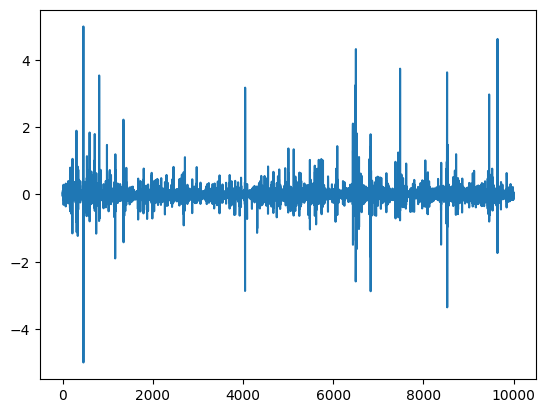

In [82]:
energy_change = jnp.clip(energy_change, min=-5, max=5)
# plt.hist(energy_change[0], bins=100, density=True)
# plt.show()
sns.lineplot(energy_change[0])
# energy_change

In [87]:
from benchmarks.metrics import calculate_ess, cumulative_avg
from benchmarks.sampling_algorithms import calls_per_integrator_step
import numpy as np

def cumulative_avg_with_weights(samples,weights):
    print(weights.shape)
    return jnp.cumsum(samples*weights, axis=0) / jnp.expand_dims((weights),1)

def ess_calculation(samples, energy_change):

    weights = jnp.expand_dims(jnp.exp(-jnp.cumsum(energy_change)),1)

    ## batch approach
    # indices = jax.pmap(lambda k, e: jax.random.categorical(key=k, logits=-jnp.cumsum(e), shape=(num_steps,)))(keys, energy_change)
    # resamples = np.zeros_like(unadjusted_samples)
    # for i in range(indices.shape[0]):
    #     resamples[i] = samples[i, indices[i], :]

    indices = jax.random.categorical(key=resample_key, logits=-jnp.cumsum(energy_change), shape=(num_steps,))
    jax.debug.print("indices, {x}", x=indices)
    print(indices.shape)
    resamples = samples[0][indices]
    # print(resamples.shape)


    def get_ess(samples, label, weights=None):

        # bias = jax.pmap(lambda s: (((cumulative_avg( s**2) - model.E_x2)**2)/model.Var_x2))(samples)
        
        if weights is not None:
            bias = (((cumulative_avg_with_weights(samples**2, weights) - model.E_x2)**2)/model.Var_x2)
        else:
            bias = (((cumulative_avg(samples**2) - model.E_x2)**2)/model.Var_x2)
        # print((jax.pmap(lambda s: (((cumulative_avg( s**2) - model.E_x2))**2))(samples)/model.Var_x2).mean(axis=[0,-1]))
        meanbias = jnp.mean(bias, axis=-1) # mean over dimensions
        # meanbias = jnp.mean(meanbias, axis=0) # mean over chains
        jax.debug.print("meanbias {x}", x=meanbias)

        sns.lineplot(meanbias[500:], label=label)

        grad_evals_per_step = calls_per_integrator_step('mclachlan')
        ess, _, _ = calculate_ess(meanbias, grad_evals_per_step=grad_evals_per_step, num_tuning_steps=0)
        return ess

    ess = get_ess(samples[0], "unweighted")
    ess_weighted = get_ess(samples[0], "weighted", weights=weights)
    ess_resampled = get_ess(resamples, "resampled")
    plt.show()
    return ess, ess_resampled, ess_weighted, samples, resamples, weights


In [88]:
ess, ess_resampled, ess_weighted,  samples, resamples, weights = ess_calculation(samples=unadjusted_samples, energy_change=energy_change)
(ess, ess_resampled, ess_weighted)

indices, [118  94 120 ... 200  46 389]
(10000,)
meanbias [0.3914457  0.342578   0.25764298 ... 0.00178005 0.00177933 0.00177744]
(10000, 1)


Array([[0.9163643 ],
       [0.91194946],
       [0.9624393 ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

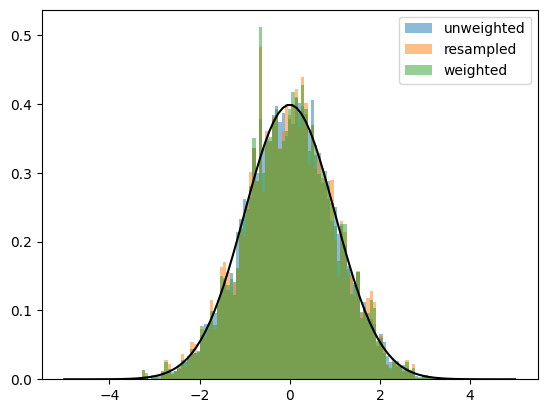

(1, 10)

In [22]:
plt.hist(samples[0,:,0], bins=100, density=True, alpha=0.5, label="unweighted")
plt.hist(resamples[:,0], bins=100, density=True, label='resampled', alpha=0.5)
plt.hist(samples[0,:,0], bins=100, density=True, alpha=0.5, weights=weights[:,0], label="weighted")
x = jnp.linspace(-5, 5, 100)
sns.lineplot(x=x, y=jax.scipy.stats.norm.pdf(x, loc=0, scale=1), color='black')
plt.show()

samples[:,0].shape

